In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")

In [2]:
import tpqoa
api = tpqoa.tpqoa("oandaMY.cfg")

In [3]:
class SMABacktester():
    ''' Classe per il backtesting di strategie SMA'''
    
    def __init__(self, symbol, SMA_s, SMA_l, start, end):
        '''
        Parametri
        ---------
        symbol: str
            simbolo del ticker per OANDA
        SMA_s: int
            finestra corta
        SMA_l: int
            finestra lunga
        start: str
            data di inizio
        end: str
            data di fine
        '''
        self._symbol = symbol
        self._SMA_s = SMA_s
        self._SMA_l = SMA_l
        self._start = start
        self._end = end
        self._results = None
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_s = {}, SMA_l = {}, start = {}, end = {})".format(self._symbol,self._SMA_s,self.SMA_l,self._start,self._end)
        
    def get_data(self): # carica i dati
        df = api.get_history(instrument = self._symbol, start = self._start, end = self._end, granularity = "D", price = "M")["c"].to_frame().dropna()
        df["logRet"]=np.log(df/df.shift(1))
        self.data=df
    
    def prepare_data(self): # contruisce il dataframe internamente 
        self.data["SMA_s"]=self.data["c"].rolling(self._SMA_s).mean()
        self.data["SMA_l"]=self.data["c"].rolling(self._SMA_l).mean()
        #return self.data
    
    def set_parameters(self, SMA_s=None, SMA_l=None):
        if SMA_s is not None:
            self._SMA_s = SMA_s
            self.data["SMA_s"]=self.data.c.rolling(SMA_s).mean()
        if SMA_l is not None:
            self._SMA_l = SMA_l
            self.data["SMA_l"]=self.data.c.rolling(SMA_l).mean()

    def test_strategy(self):
        data=self.data.copy().dropna()
        data["posizione"]=np.where(data.SMA_s>data.SMA_l,+1,-1)
        data["strategia"]= data.posizione.shift(1) * data.logRet
        data.dropna(inplace=True)
        data["cumLogRet"]= data.logRet.cumsum()
        data["cumStrategia"]= data.strategia.cumsum()
        # performance = np.exp(data.cumStrategia.iloc[-1])
        # outPerformance = performance - np.exp(data.cumLogRet.iloc[-1])
        performance = data.cumStrategia.iloc[-1]
        outPerformance = performance - data.cumLogRet.iloc[-1]
        maxDrawdown=(data.strategia.cumsum().cummax()-data.strategia.cumsum()).max()
        self._results=data
        return round(performance,6),round(outPerformance,6),round(maxDrawdown,6)
    
    def plot_results(self):
        if self._results is None:
            print("Devi prima chiamare test_strategy()")
        else:
            titolo="{}    SMA_S = {}     SMA_L = {}".format(self._symbol,self._SMA_s,self._SMA_l)
            self._results[["cumLogRet","cumStrategia"]].plot(figsize=(25,15))
            plt.legend(fontsize=18)
            plt.title(titolo,fontsize=22)
    
    def optimize_parameters(self, SMA_s_range, SMA_l_range): # ranges are tuples
        ''' Trova la stretgia ottimale all\'interno dei range dei parametri indicati
        
        Parametri
        ---------
        SMA_s_range: tuple di 2 o 3 int
            inizio e fine (e eventualmente step) del range per la finestra corta
        SMA_l_range: tuple di 2 o 3 int
            inizio e fine (e eventualmente step) del range per la finestra corta
        '''
        
        combinazioni = list(product(range(SMA_s_range[0],SMA_s_range[1]),range(SMA_l_range[0],SMA_l_range[1]) ))
        # combinazioni = list(product(range(*SMA_s_range),range(*SMA_l_range) ))
        risultati= []
        for comb in combinazioni:
            self.set_parameters(comb[0],comb[1])
            risultati.append(self.test_strategy()[0])
        
        best_performance = np.max(risultati)
        best_combinazione = combinazioni[np.argmax(risultati)]
        
        # eseguiamo la strategia migliore
        self.set_parameters(best_combinazione[0],best_combinazione[1])
        self.test_strategy()
        
        # mettiamo i risulati in un bel dataframe
        AllResults = pd.DataFrame(combinazioni, columns=["SMA_s","SMA_l"])
        AllResults["performance"]= risultati
        self.results_overview = AllResults
        
        return best_combinazione, best_performance
    

In [10]:
trainer=SMABacktester("EUR_USD",50,250,"2009-10-10","2020-10-10")

In [12]:
trainer.data.head(55)

c    logRet     SMA_s  SMA_l
time                                                   
2008-10-09 21:00:00  1.33977       NaN       NaN    NaN
2008-10-10 21:00:00  1.33923 -0.000403       NaN    NaN
2008-10-11 21:00:00  1.35705  0.013218       NaN    NaN
2008-10-12 21:00:00  1.35818  0.000832       NaN    NaN
2008-10-13 21:00:00  1.36174  0.002618       NaN    NaN
2008-10-14 21:00:00  1.34977 -0.008829       NaN    NaN
2008-10-15 21:00:00  1.34543 -0.003221       NaN    NaN
2008-10-16 21:00:00  1.34033 -0.003798       NaN    NaN
2008-10-18 21:00:00  1.34210  0.001320       NaN    NaN
2008-10-19 21:00:00  1.33425 -0.005866       NaN    NaN
2008-10-20 21:00:00  1.30618 -0.021262       NaN    NaN
2008-10-21 21:00:00  1.28546 -0.015990       NaN    NaN
2008-10-22 21:00:00  1.29329  0.006073       NaN    NaN
2008-10-23 21:00:00  1.26160 -0.024809       NaN    NaN
2008-10-25 21:00:00  1.25535 -0.004966       NaN    NaN
2008-10-26 21:00:00  1.24929 -0.004839       NaN    NaN
2008-10-27 21:00:00  1.26809  0.014936       NaN    NaN
2008-10-28 21:00:00  1.29589  0.021686       NaN    NaN
2008-10-29 21:00:00  1.29129 -0.003556       NaN    NaN
2008-10-30 21:00:00  1.27163 -0.015342       NaN    NaN
2008-11-01 21:00:00  1.27429  0.002090       NaN    NaN
2008-11-02 22:00:00  1.26421 -0.007942       NaN    NaN
2008-11-03 22:00:00  1.29795  0.026339       NaN    NaN
2008-11-04 22:00:00  1.29542 -0.001951       NaN    NaN
2008-11-05 22:00:00  1.27144 -0.018685       NaN    NaN
2008-11-06 22:00:00  1.27134 -0.000079       NaN    NaN
2008-11-07 22:00:00  1.27110 -0.000189       NaN    NaN
2008-11-08 22:00:00  1.28110  0.007836       NaN    NaN
2008-11-09 22:00:00  1.27498 -0.004789       NaN    NaN
2008-11-10 22:00:00  1.25220 -0.018028       NaN    NaN
2008-11-11 22:00:00  1.25045 -0.001399       NaN    NaN
2008-11-12 22:00:00  1.27675  0.020814       NaN    NaN
2008-11-13 22:00:00  1.25997 -0.013230       NaN    NaN
2008-11-15 22:00:00  1.25311 -0.005459       NaN    NaN
2008-11-16 22:00:00  1.26498  0.009428       NaN    NaN
2008-11-17 22:00:00  1.26173 -0.002573       NaN    NaN
2008-11-18 22:00:00  1.24879 -0.010309       NaN    NaN
2008-11-19 22:00:00  1.24522 -0.002863       NaN    NaN
2008-11-20 22:00:00  1.25823  0.010394       NaN    NaN
2008-11-22 22:00:00  1.25858  0.000278       NaN    NaN
2008-11-23 22:00:00  1.29560  0.028990       NaN    NaN
2008-11-24 22:00:00  1.30635  0.008263       NaN    NaN
2008-11-25 22:00:00  1.28782 -0.014286       NaN    NaN
2008-11-26 22:00:00  1.29027  0.001901       NaN    NaN
2008-11-27 22:00:00  1.26859 -0.016945       NaN    NaN
2008-11-28 22:00:00  1.26859  0.000000       NaN    NaN
2008-11-29 22:00:00  1.27105  0.001937       NaN    NaN
2008-11-30 22:00:00  1.26089 -0.008026       NaN    NaN
2008-12-01 22:00:00  1.27131  0.008230       NaN    NaN
2008-12-02 22:00:00  1.27146  0.000118  1.287394    NaN
2008-12-03 22:00:00  1.27756  0.004786  1.286150    NaN
2008-12-04 22:00:00  1.27112 -0.005054  1.284787    NaN
2008-12-05 22:00:00  1.27138  0.000205  1.283074    NaN
2008-12-06 22:00:00  1.27246  0.000849  1.281360    NaN
2008-12-07 22:00:00  1.29625  0.018523  1.280050    NaN

In [16]:
trainer.optimize_parameters((30,90), (100,200))

((85, 122), 0.775402)

In [17]:
trainer.test_strategy() # attenzione che è su 11 anni

(0.775402, 0.916535, 0.114583)

In [24]:
tester = SMABacktester("EUR_USD",85,122,"2020-10-11","2021-10-10")

In [25]:
tester.test_strategy() # questo invece è solo su 1 anni

(0.09169, 0.034821, 0.056324)

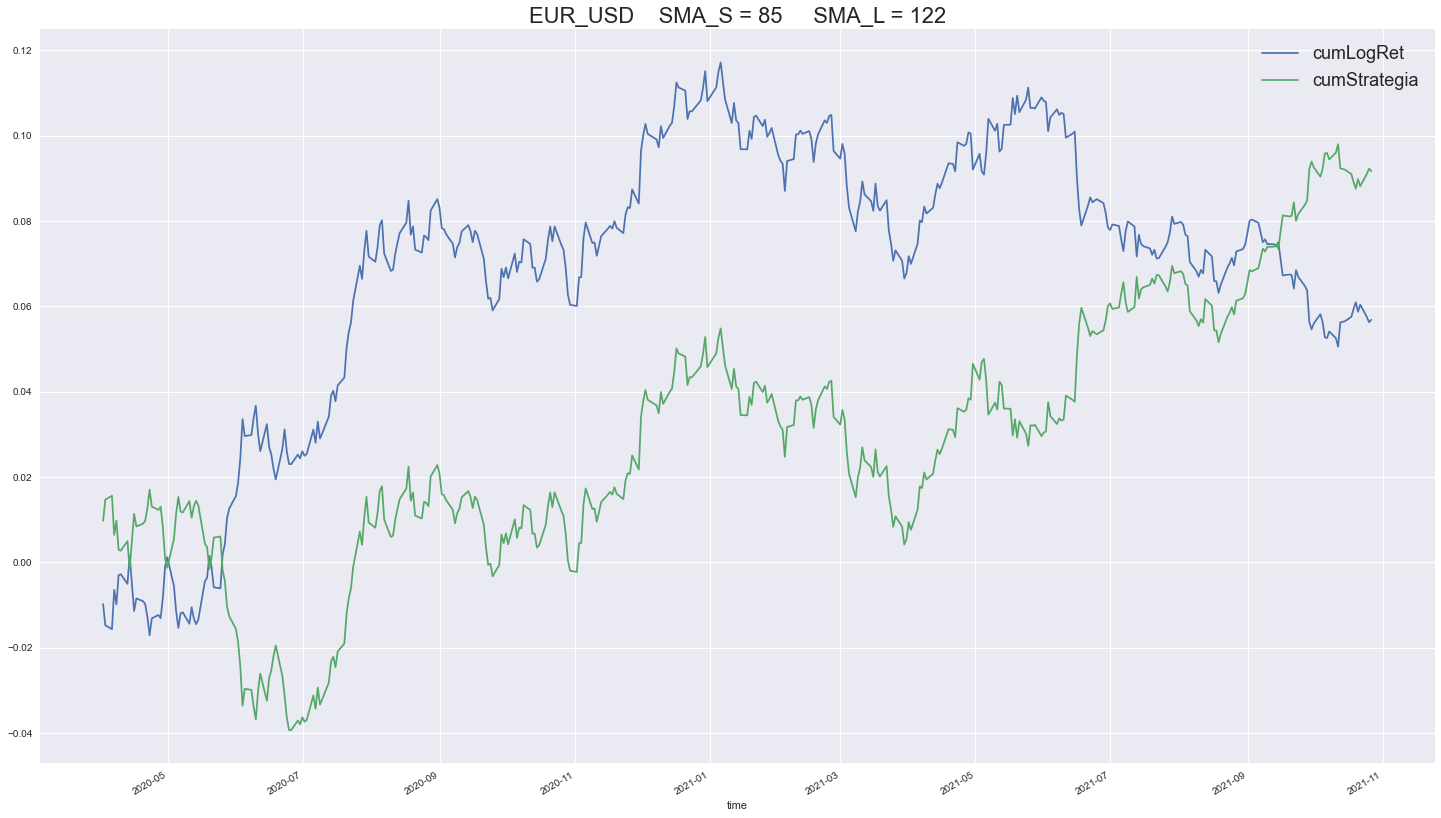

In [26]:
tester.plot_results()

In [27]:
tester = SMABacktester("GBP_USD",85,122,"2021-10-11","2022-10-10")
tester.test_strategy()

(0.012869, -0.08875, 0.103972)

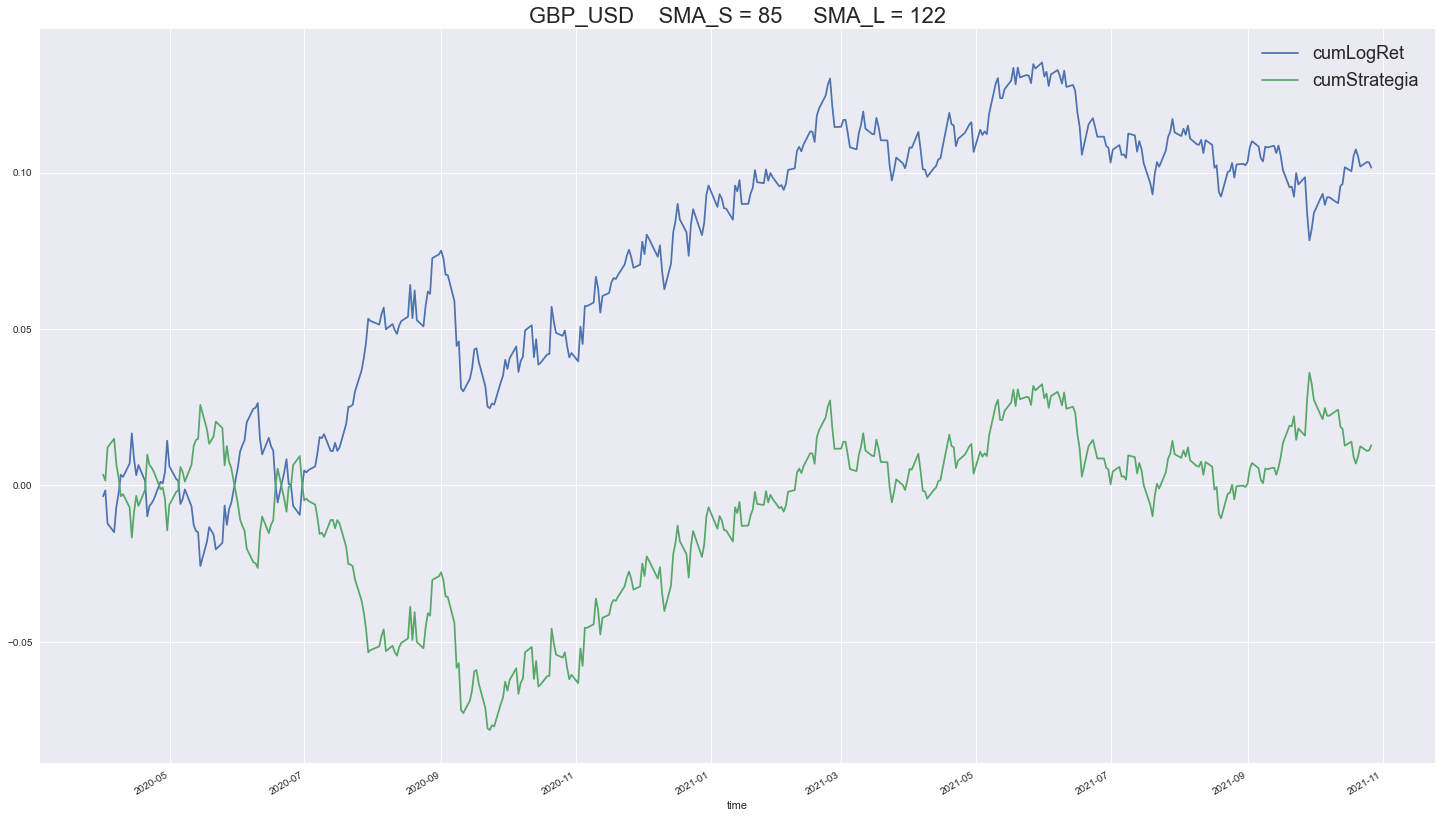

In [28]:
tester.plot_results()